In [1]:
import warnings
warnings.filterwarnings(action='ignore',category=FutureWarning)

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Concatenate,Embedding,LayerNormalization,Dropout
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
tf.keras.backend.set_floatx('float32')

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

# <font color=red>TRAINING</font>

In [38]:
DATA_PATH='E:/Jupyter files/ROUGH/data.csv'
CHECKPOINT_PATH = 'E:/Jupyter files/ROUGH/check_temp'
os.mkdir(CHECKPOINT_PATH)

SAMPLES=30000
MAX_WORDS=20
VOCAB=10000
BATCH_SIZE=64

## Load training data

In [5]:
train=pd.read_csv(DATA_PATH)
train=train.drop("source",axis=1)
train.head()

,english_sentence,hindi_sentence
0,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।
3,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
4,.The ending portion of these Vedas is called U...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।


In [6]:
print("Total samples: ", len(train))

Total samples:  127607


## Randomly sample training data

In [7]:
train=train.sample(SAMPLES)

## Add <start\> and <end\> token

In [8]:
train['english_sentence'] = train['english_sentence'].apply(lambda x: '<start> '+str(x)+' <end>')
train['hindi_sentence'] = train['hindi_sentence'].apply(lambda x: '<start> '+str(x)+' <end>')
train.head()

,english_sentence,hindi_sentence
36940,"<START> you'll find about half of that money, ...","<START> आप को इससे लगभग आधे का आंकड़ा मिलेगा, ..."
78912,<START> surrounded by 150 family and friends. ...,<START> जिसमें 150 परिजनों और मित्रों ने शिरकत...
93613,<START> Hereon they have based their compulati...,<START> इसी को उन्होंने अपनी गणना-विधियों का ख...
54055,"<START> Another small water body, called the [...","<START> एक और छोटी पानी की होद, जिसे जसेरी कहत..."
91744,"<START> because we are in need of guidance, <END>","<START> क्यों कि हमें मार्गदर्शन, <END>"


## Tokenize and pad english sentence

In [9]:
tokenizerE = Tokenizer(num_words=VOCAB, 
                       oov_token='<OOV>', 
                       lower=True, 
                       filters='#$!"%&()*+,-./:;=?@[\\]^_`{|}~\t\n')

tokenizerE.fit_on_texts(train['english_sentence'])

eng_inp = tokenizerE.texts_to_sequences(train['english_sentence'])

eng_inp = pad_sequences(eng_inp,
                        maxlen=MAX_WORDS,
                        truncating='post',
                        padding='post',
                        dtype='int64')

## Tokenize and pad hindi sentence

In [10]:
tokenizerH = Tokenizer(num_words=VOCAB,
                       oov_token='<OOV>',
                       lower=True,
                       filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')

tokenizerH.fit_on_texts(train['hindi_sentence'])

hin_inp=tokenizerH.texts_to_sequences(train['hindi_sentence'])

hin_inp=pad_sequences(hin_inp,
                      maxlen=MAX_WORDS,
                      truncating='post',
                      padding='post',
                      dtype='int64')

## Creating reverse hindi dictionary

In [11]:
rev_hin_dict = dict(map(reversed, tokenizerH.word_index.items()))

## Creating dataset

In [12]:
dataset = tf.data.Dataset.from_tensor_slices((eng_inp,hin_inp)).shuffle(SAMPLES).batch(BATCH_SIZE,drop_remainder=True)

## Creating the model

In [13]:
def pos_enc(posi,dim):
    mat=1 / 10000 ** ( 2*(np.expand_dims(np.arange(0,dim),1)//2) / np.float32(dim) )    
    pos=np.expand_dims(np.arange(0,posi),1)   
    mat=np.reshape(mat,(1,dim))   
    mul=pos*mat
    mul[:, 0::2]=np.sin(mul[:, 0::2])
    mul[:, 1::2]=np.cos(mul[:, 1::2])
    mul=np.reshape(mul,(1,posi,dim))  
    return tf.cast(mul,dtype=tf.float32)

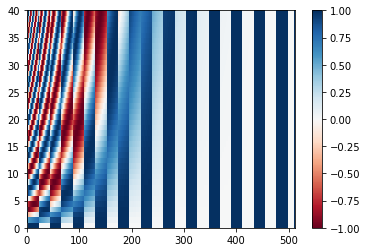

In [14]:
mul=pos_enc(40,512)

plt.pcolormesh(mul[0],cmap='RdBu')
plt.colorbar()
plt.show()

In [15]:
def padding_mask(ans):
    ans=tf.cast(tf.math.equal(ans,0),tf.float32)
    ans=ans[:,tf.newaxis,tf.newaxis,:]
    return ans

In [16]:
def look_ahead(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

In [17]:
def attention(q,k,v,mask):
    matmul1=tf.matmul(q,k,transpose_b=True)
    scale = matmul1 / tf.math.sqrt( tf.cast(tf.shape(k)[-1],dtype=tf.float32))
    if mask is not None:
        scale+=mask*(-1e9)
    attn_wt = tf.nn.softmax(scale,axis=-1)
    matmul2 = tf.matmul(attn_wt,v)
    return matmul2,attn_wt

In [18]:
class multi_head_attention(tf.keras.layers.Layer):
    def __init__(self,num_heads,d):       
        super(multi_head_attention,self).__init__()       
        self.d=d
        self.num_heads=num_heads
        assert d%self.num_heads == 0
        self.depth=d//self.num_heads       
        self.denseQ=Dense(self.d)
        self.denseK=Dense(self.d)
        self.denseV=Dense(self.d)
        self.denseOUT=Dense(self.d)
    
    def split_heads(self,x,batch):        
        x=tf.reshape(x, (batch, -1, self.num_heads, self.depth))
        return tf.transpose(x,perm=[0,2,1,3])
    
    def __call__(self,q,k,v,mask):
        batch=tf.shape(q)[0]
        q=self.denseQ(q)
        k=self.denseK(k)
        v=self.denseV(v)       
        q=self.split_heads(q,batch)
        k=self.split_heads(k,batch)
        v=self.split_heads(v,batch)
        out1attn,out2attnwt=attention(q,k,v,mask)
        out1attn=tf.transpose(out1attn,perm=[0,2,1,3])
        out1attn2=tf.reshape(out1attn,(batch,-1,self.d))
        out1attn3=self.denseOUT(out1attn2)
        return out1attn3,out2attnwt

In [19]:
def feed_forward(d1,d2):
    return Sequential([
        Dense(d1,activation='relu'),
        Dense(d2)
    ])

In [20]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,num_heads,d,D):
        super(EncoderLayer,self).__init__()        
        self.mha=multi_head_attention(num_heads,d)
        self.ffn=feed_forward(D,d)       
        self.norm1=LayerNormalization(epsilon=1e-6)
        self.norm2=LayerNormalization(epsilon=1e-6)        
        self.drop1=Dropout(0.1)
        self.drop2=Dropout(0.1)
    
    def __call__(self,x,training,mask):
        mha,_=self.mha(x,x,x,mask)
        mha=self.drop1(mha,training=training)       
        tmp1=self.norm1(x+mha)              
        tmp2=self.ffn(tmp1)
        tmp2=self.drop2(tmp2,training=training)  
        tmp3=self.norm2(tmp1+tmp2)
        return tmp3

In [21]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,num_heads,d,D):
        super(DecoderLayer,self).__init__()     
        self.mha1=multi_head_attention(num_heads,d)
        self.mha2=multi_head_attention(num_heads,d)
        self.ffn=feed_forward(D,d)      
        self.norm1=LayerNormalization(epsilon=1e-6)
        self.norm2=LayerNormalization(epsilon=1e-6)        
        self.norm3=LayerNormalization(epsilon=1e-6)       
        self.drop1=Dropout(0.1)
        self.drop2=Dropout(0.1)
        self.drop3=Dropout(0.1)
        
    def __call__(self, x, encout, training, look_ahead, padding_mask):
        mha1,attnwt1=self.mha1(x,x,x,look_ahead)
        mha1=self.drop1(mha1,training=training)        
        tmp1=self.norm1(x+mha1)       
        mha2,attnwt2=self.mha2(tmp1,encout,encout,padding_mask)
        mha2=self.drop2(mha2,training=training)        
        tmp2=self.norm2(tmp1+mha2)    
        tmp3=self.ffn(tmp2)
        tmp3=self.drop3(tmp3,training=training)
        tmp4=self.norm3(tmp2+tmp3)
        return tmp4,attnwt1,attnwt2

In [22]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self,vocab,d,maxposencsize,num_heads,D,num_layers):
        super(Encoder,self).__init__()
        self.d=d
        self.num_layers=num_layers          
        self.emb=Embedding(vocab,d)
        self.posenc=pos_enc(maxposencsize,self.d)
        self.enclayers=[EncoderLayer(num_heads,d,D) for _ in range(num_layers)]
        self.drop=Dropout(0.1)
      
    def __call__(self,x,training,mask):
        tmp=tf.shape(x)[1]
        x=self.emb(x)   
        x*=tf.math.sqrt(tf.cast(self.d,tf.float32))    
        x+=self.posenc[:,:tmp,:]     
        x=self.drop(x,training=training)
        for i in range(self.num_layers):
            x=self.enclayers[i](x,training,mask)
        return x

In [23]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self,vocab,d,maxposencsize,num_heads,D,num_layers):
        super(Decoder,self).__init__()
        self.d=d
        self.num_layers=num_layers              
        self.emb=Embedding(vocab,d)    
        self.posenc=pos_enc(maxposencsize,d)
        self.declayers=[DecoderLayer(num_heads,d,D) for _ in range(num_layers)]
        self.drop=Dropout(0.1)
       
    def __call__(self,x,encout,training,look_ahead, padding_mask):
        tmp=tf.shape(x)[1]
        attnout={}
        x=self.emb(x)    
        x*=tf.math.sqrt(tf.cast(self.d,tf.float32))     
        x+=self.posenc[:,:tmp,:]       
        x=self.drop(x,training=training)
        for i in range(self.num_layers):
            x,attnwt1,attnwt2=self.declayers[i](x,encout,training,look_ahead, padding_mask)
            attnout['decoder_layer{}_block1'.format(i+1)] = attnwt1
            attnout['decoder_layer{}_block2'.format(i+1)] = attnwt2
        return x,attnout

In [24]:
class Transformer(tf.keras.Model):
    def __init__(self,vocab,d,maxposencsize,num_heads,D,num_layers):
        super(Transformer,self).__init__()
        self.encoder=Encoder(vocab,d,maxposencsize,num_heads,D,num_layers)
        self.decoder=Decoder(vocab,d,maxposencsize,num_heads,D,num_layers)
        self.dense=Dense(vocab)
        
    def __call__(self,x,y,training,mask,look_ahead, padding_mask):
        encoder_call=self.encoder(x,training,mask)
        decoder_call,attnwt_call=self.decoder(y,encoder_call,training,look_ahead, padding_mask)
        decoder_call=self.dense(decoder_call)
        return decoder_call,attnwt_call

In [25]:
d=128
D=512
num_heads=8
num_layers=4
maxposencsize=VOCAB
EPOCH=30

In [26]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self,d):
        super(CustomSchedule,self).__init__()
        self.d=d
    def __call__(self,step):
        arg1=step**-0.5
        arg2=step*(4000**-1.5)
        lrate=(self.d**-0.5)*tf.math.minimum(arg1,arg2)
        return lrate

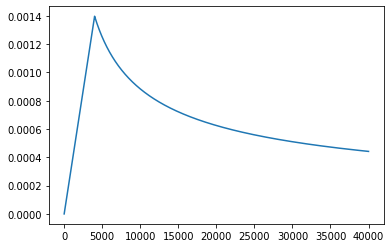

In [27]:
lrate=CustomSchedule(d)
optimizer=tf.keras.optimizers.Adam(lrate,beta_1=0.9,beta_2=0.98,epsilon=1e-9)

plt.plot(lrate(tf.range(40000, dtype=tf.float32)))
plt.show()

In [28]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
train_loss = tf.keras.metrics.Mean(name='train_loss')

In [29]:
def create_masks(x,y):
    tmp1=padding_mask(x)
    tmp2=padding_mask(x)    
    tmp3=look_ahead(tf.shape(y)[1])
    tmp4=padding_mask(y)
    tmp5=tf.maximum(tmp3,tmp4)     
    return tmp1,tmp5,tmp2

In [30]:
transformer = Transformer(VOCAB,d,maxposencsize,num_heads,D,num_layers)

In [40]:
checkpoint_path = CHECKPOINT_PATH
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

In [32]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def training(x,y):
    y_inp=y[:,:-1]
    y_real=y[:,1:]   
    mask,look_ahead, padding_mask=create_masks(x,y_inp)                                            
    with tf.GradientTape() as tape:         
        pred,_=transformer(x, y_inp, True, mask, look_ahead, padding_mask)
        loss=loss_function(y_real,pred)              
    variables=transformer.trainable_variables
    gradients=tape.gradient(loss, variables) 
    optimizer.apply_gradients(zip(gradients, variables))
    train_loss(loss)

In [33]:
#ckpt.restore(ckpt_manager.latest_checkpoint)

In [69]:
import time
for epoch in range(EPOCH): 
    start_time=time.time()     
    train_loss.reset_states()   
    print("Starting epoch {}".format(epoch+1))       
    for x_batch,y_batch in dataset:
        training(x_batch, y_batch)       
    end_time=time.time()
    print('loss = {:.4f}\ttime taken = {:.2f} secs'.format(train_loss.result(),end_time-start_time))      
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()

Starting epoch 1
loss = 1.5049	time taken = 43.28 secs
Starting epoch 2
loss = 1.4675	time taken = 43.61 secs
Starting epoch 3
loss = 1.4340	time taken = 43.34 secs
Starting epoch 4
loss = 1.3958	time taken = 43.60 secs
Starting epoch 5
loss = 1.3678	time taken = 43.76 secs


# <font color=red>TESTING</font>

In [66]:
def evaluate(text,plot=False):   
 
    text=tokenizerE.texts_to_sequences(text)
    text=np.array(text).astype('int64')
    text=pad_sequences(text,maxlen=MAX_WORDS,truncating='post',padding='post',dtype='int64')

    decinp=[tokenizerH.word_index['<start>']]
    decinp=tf.expand_dims(decinp,0)
    for i in range (MAX_WORDS):
        m1,m2,m3=create_masks(text,decinp)
        p,a=transformer(text,decinp,False,m1,m2,m3)
        p=p[: ,-1:, :] 
        predicted_id = tf.cast(tf.argmax(p, axis=-1), tf.int32)
        decinp=tf.concat([decinp,predicted_id],axis=-1)

    ans=sentence(decinp.numpy()[0])
     
    if plot==True:
        att=[a['decoder_layer4_block2'].numpy()[0,i] for i in range(num_heads)]
        for j in range (num_heads):
            plt.matshow(att[j])
            plt.show()
            
    print("Translated Sentence: ",ans)

In [67]:
def sentence(x):
    ans=''
    for w in x:
        ans+=rev_hin_dict[w]+' '
        if w == tokenizerH.word_index['<end>']:
            return ans
    return ans

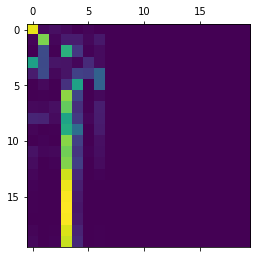

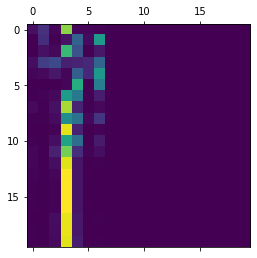

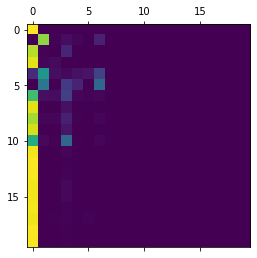

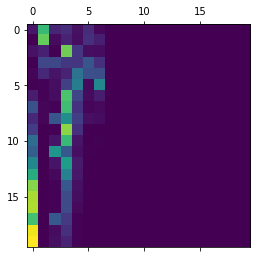

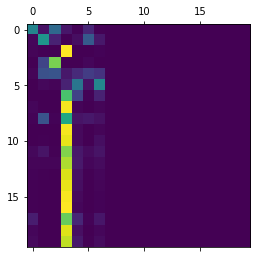

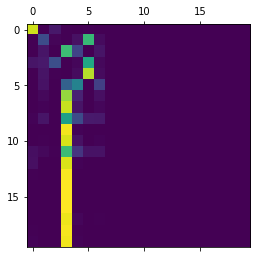

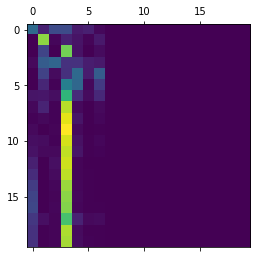

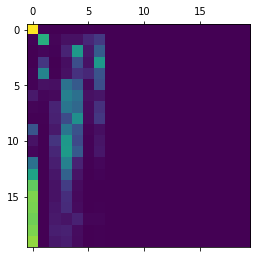

Translated Sentence:  <start> मुझे लगता है आप इसे देख सकते हैं <end>


In [93]:
text="I think you should see this too"
evaluate([text],plot=True)